In [47]:
# from project_lib import Project
# project = Project(project_id='19882a4a-41a6-4cd6-be72-c870df9ed99c', project_access_token='p-876f32649fa8aa216cb596a2db6cfbba35a2fbe6')
# pc = project.project_context

# 1. Business Understanding

Cancellations are part of the everyday life of hotels. For some time now, hotels have been charging no/barely any cancellation fees. This increasingly attracts customers to make bookings that are then not taken at the last second.
Is it possible to use machine learning approaches to determine the size by given parameters and to predict the cancellations by overbooking hotels accordingly in order to fill the hotel nonetheless in case of cancellations that are not perceived?

# 2. Data and Data Understanding

The data sets contain all kinds of data recorded about the guests. Characteristics regarding children, bookings via travel agencies, etc. could provide information on whether they have a higher cancellation rate.

## 2.1. Import of Relevant Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

## 2.2. Read Data

In [2]:
# my_file = project.get_file()

# my_file.seek(0)
df = pd.read_csv("https://storage.googleapis.com/ml-service-repository-datastorage/Prediction_cancellation_of_hotel_bookings_data.csv")

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
def attribute_description(data):
    longestColumnName = len(max(np.array(data.columns), key=len))
    for col in data.columns:
        description = ''
        col_dropna = data[col].dropna()
        example = col_dropna.sample(1).values[0]
        if type(example) == str:
            description = 'str '
            if len(col_dropna.unique()) < 10:
                description += '['
                description += '; '.join([ f'"{name}"' for name in col_dropna.unique()])
                description += ']'
            else:
                description += '[ example: "'+ example + '" ]'
        else:
            description = str(type(example))
        print(col.ljust(longestColumnName)+ f':   {description}')

In [4]:
attribute_description(df)

hotel                         :   str ["Resort Hotel"; "City Hotel"]
is_canceled                   :   <class 'numpy.int64'>
lead_time                     :   <class 'numpy.int64'>
arrival_date_year             :   <class 'numpy.int64'>
arrival_date_month            :   str [ example: "October" ]
arrival_date_week_number      :   <class 'numpy.int64'>
arrival_date_day_of_month     :   <class 'numpy.int64'>
stays_in_weekend_nights       :   <class 'numpy.int64'>
stays_in_week_nights          :   <class 'numpy.int64'>
adults                        :   <class 'numpy.int64'>
children                      :   <class 'numpy.float64'>
babies                        :   <class 'numpy.int64'>
meal                          :   str ["BB"; "FB"; "HB"; "SC"; "Undefined"]
country                       :   str [ example: "GBR" ]
market_segment                :   str ["Direct"; "Corporate"; "Online TA"; "Offline TA/TO"; "Complementary"; "Groups"; "Undefined"; "Aviation"]
distribution_channel          :

In [5]:
df.describe(include='all')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
count,119390,119390.000000,119390.000000,119390.000000,119390,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,...,119390,103050.000000,6797.000000,119390.000000,119390,119390.000000,119390.000000,119390.000000,119390,119390
unique,2,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,...,3,NaN,NaN,NaN,4,NaN,NaN,NaN,3,926
top,City Hotel,NaN,NaN,NaN,August,NaN,NaN,NaN,NaN,NaN,...,No Deposit,NaN,NaN,NaN,Transient,NaN,NaN,NaN,Check-Out,2015-10-21
freq,79330,NaN,NaN,NaN,13877,NaN,NaN,NaN,NaN,NaN,...,104641,NaN,NaN,NaN,89613,NaN,NaN,NaN,75166,1461
mean,NaN,0.370416,104.011416,2016.156554,NaN,27.165173,15.798241,0.927599,2.500302,1.856403,...,NaN,86.693382,189.266735,2.321149,NaN,101.831122,0.062518,0.571363,NaN,NaN
std,NaN,0.482918,106.863097,0.707476,NaN,13.605138,8.780829,0.998613,1.908286,0.579261,...,NaN,110.774548,131.655015,17.594721,NaN,50.535790,0.245291,0.792798,NaN,NaN
min,NaN,0.000000,0.000000,2015.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,...,NaN,1.000000,6.000000,0.000000,NaN,-6.380000,0.000000,0.000000,NaN,NaN
25%,NaN,0.000000,18.000000,2016.000000,NaN,16.000000,8.000000,0.000000,1.000000,2.000000,...,NaN,9.000000,62.000000,0.000000,NaN,69.290000,0.000000,0.000000,NaN,NaN
50%,NaN,0.000000,69.000000,2016.000000,NaN,28.000000,16.000000,1.000000,2.000000,2.000000,...,NaN,14.000000,179.000000,0.000000,NaN,94.575000,0.000000,0.000000,NaN,NaN
75%,NaN,1.000000,160.000000,2017.000000,NaN,38.000000,23.000000,2.000000,3.000000,2.000000,...,NaN,229.000000,270.000000,0.000000,NaN,126.000000,0.000000,1.000000,NaN,NaN


## 2.3. Data Cleaning

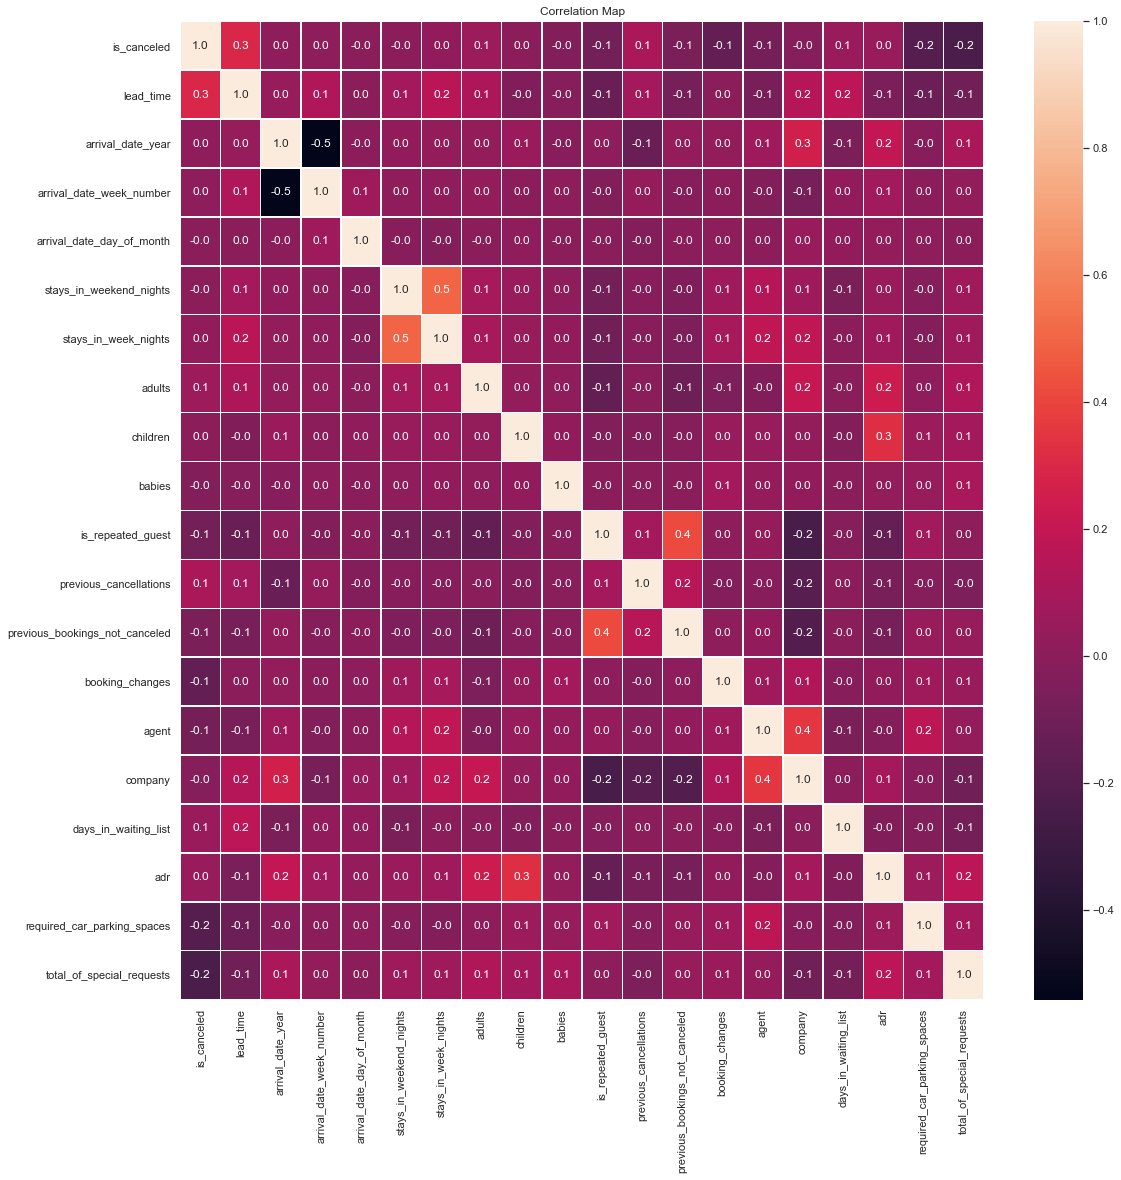

In [6]:
f,ax=plt.subplots(figsize = (18,18))
sns.heatmap(df.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

In [7]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [8]:
df = df.drop(['reservation_status'], axis=1)

In [9]:
df = df.drop(['stays_in_weekend_nights'], axis=1)

In [10]:
df = df.drop(['reservation_status_date'], axis=1)

In [11]:
df = df.drop(['arrival_date_day_of_month'], axis=1)

In [12]:
df = df.drop(['arrival_date_year'], axis=1)

In [13]:
df = df.drop(['arrival_date_month'], axis=1)

In [14]:
df = df.drop(['arrival_date_week_number'], axis=1)

In [15]:
df = df.drop(['required_car_parking_spaces'], axis=1)

In [16]:
df = df.drop(['previous_bookings_not_canceled'], axis=1)

In [17]:
df = df.drop(['total_of_special_requests'], axis=1)

In [18]:
df = df.drop(['agent'], axis=1)

In [19]:
df = df.drop(['company'], axis=1)

In [20]:
df = df.drop(['adr'], axis=1)

In [21]:
df = df.dropna(axis=0)

## 2.4. Test for Multicollinearity

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = df[['lead_time', 'is_repeated_guest', 'adults', 'booking_changes', 'previous_cancellations', 'is_canceled', 'stays_in_week_nights', 'babies', 'days_in_waiting_list']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['Features'] = variables.columns

In [23]:
vif

,VIF,Features
0,2.285568,lead_time
1,1.033605,is_repeated_guest
2,3.354523,adults
3,1.143147,booking_changes
4,1.037159,previous_cancellations
5,1.759416,is_canceled
6,2.680081,stays_in_week_nights
7,1.015332,babies
8,1.049190,days_in_waiting_list


## 2.5. Descriptive Analysis

array([[<AxesSubplot:title={'center':'is_canceled'}>,
        <AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'stays_in_week_nights'}>],
       [<AxesSubplot:title={'center':'adults'}>,
        <AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'babies'}>],
       [<AxesSubplot:title={'center':'is_repeated_guest'}>,
        <AxesSubplot:title={'center':'previous_cancellations'}>,
        <AxesSubplot:title={'center':'booking_changes'}>],
       [<AxesSubplot:title={'center':'days_in_waiting_list'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

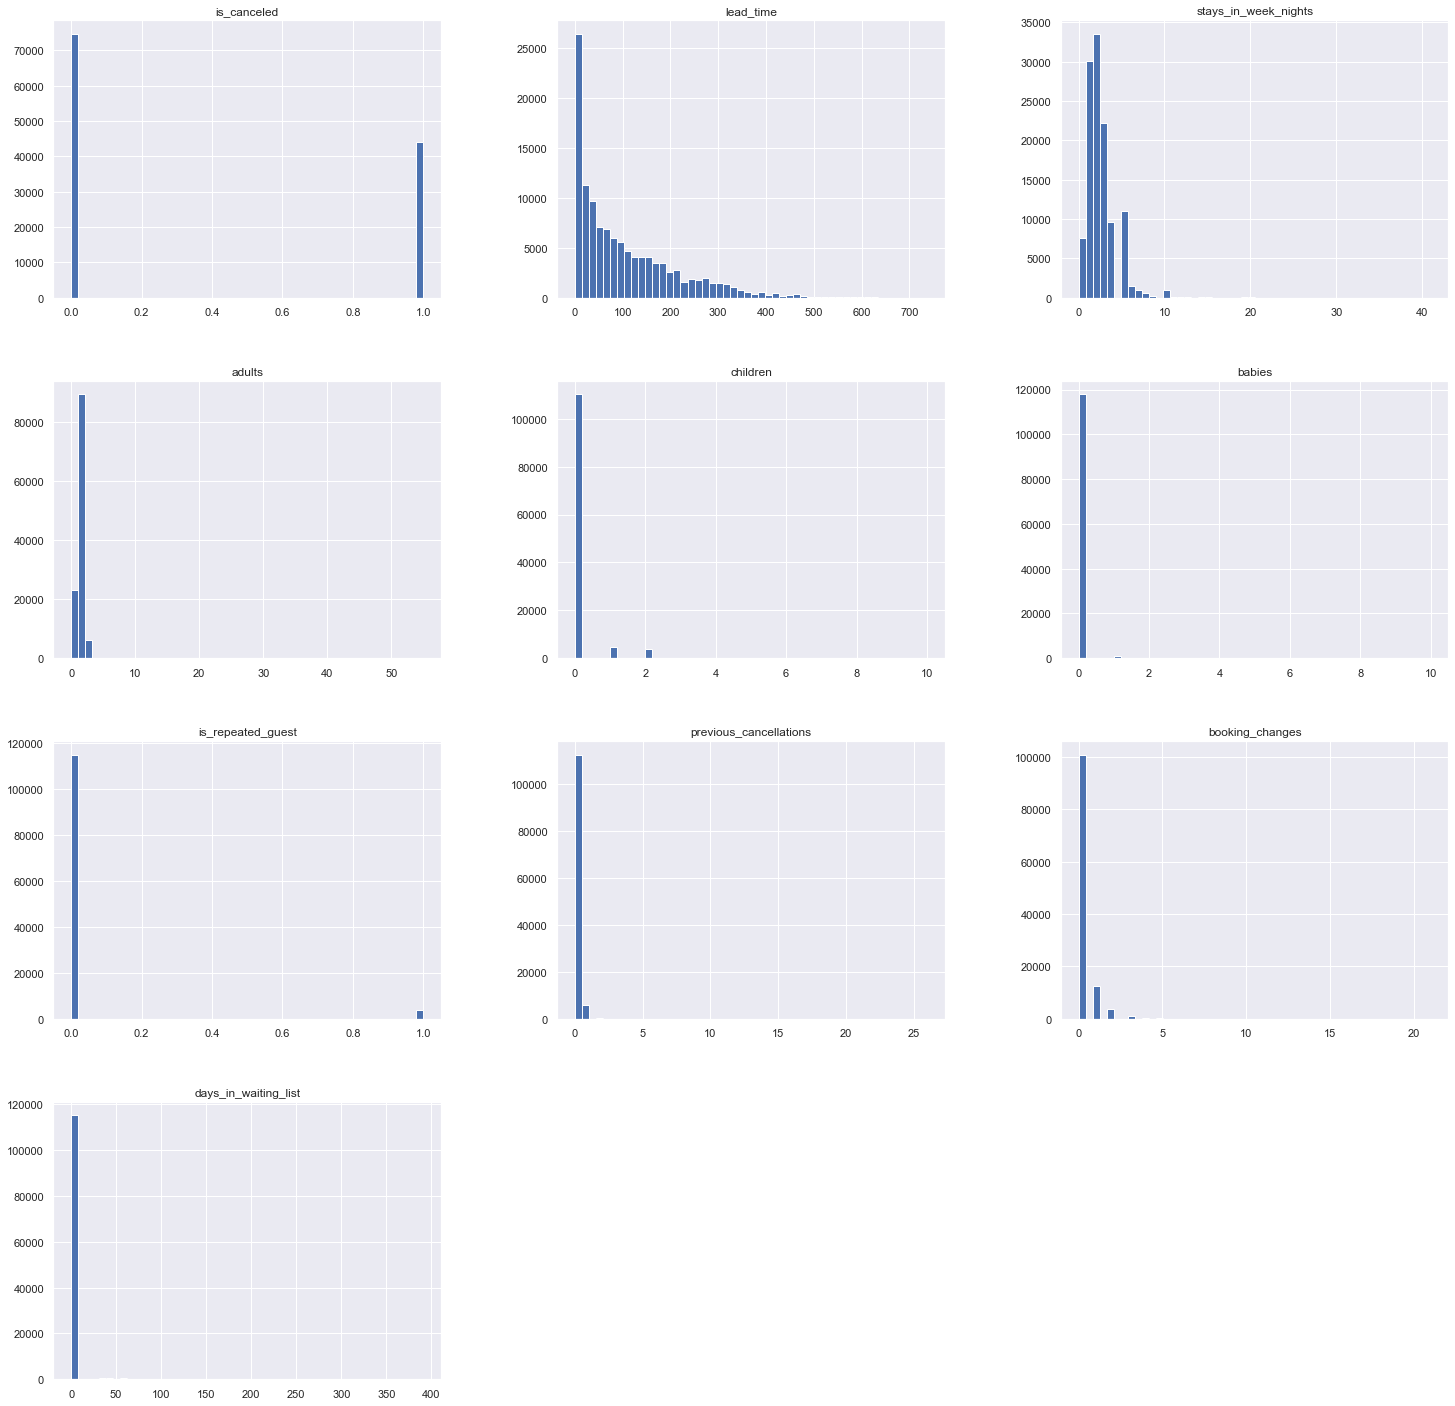

In [24]:
df.hist(figsize=(25,25), bins=50)

# 3. Data Preparation

## 3.1. Recoding of Categorical Variables

In [27]:
df_dummies = pd.get_dummies(df, drop_first=True) # 0-1 encoding for categorical values
df_dummies.head()

,is_canceled,lead_time,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,0,2,0.0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,1,0
1,0,737,0,2,0.0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,1,0
2,0,7,1,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,13,1,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,14,2,2,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [28]:
#df_dummies.to_csv('train_dummies.csv', index = False) 

In [29]:
df_dummies.axes[0]

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            119380, 119381, 119382, 119383, 119384, 119385, 119386, 119387,
            119388, 119389],
           dtype='int64', length=118898)

In [30]:
df_dummies.axes[1]

Index(['is_canceled', 'lead_time', 'stays_in_week_nights', 'adults',
       'children', 'babies', 'is_repeated_guest', 'previous_cancellations',
       'booking_changes', 'days_in_waiting_list',
       ...
       'assigned_room_type_H', 'assigned_room_type_I', 'assigned_room_type_K',
       'assigned_room_type_L', 'assigned_room_type_P',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'],
      dtype='object', length=226)

## 4. Modelling and Evaluation

## 4.1. Test and Train Data

In [33]:
target = df_dummies['is_canceled'] # feature to be predicted
predictors = df_dummies.drop(['is_canceled'], axis = 1) # all other features are used as predictors

In [34]:
predictors.head()

,lead_time,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,hotel_Resort Hotel,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,342,0,2,0.0,0,0,0,3,0,1,...,0,0,0,0,0,0,0,0,1,0
1,737,0,2,0.0,0,0,0,4,0,1,...,0,0,0,0,0,0,0,0,1,0
2,7,1,1,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,13,1,1,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,14,2,2,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=123)

## 4.2. DecisionTree

In [36]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, tree.predict(X_test)).ravel() 
print(tn, fp, fn, tp)

12972 2052 2305 6451


In [38]:
print(classification_report(y_train, tree.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     59721
           1       0.99      0.94      0.97     35397

    accuracy                           0.98     95118
   macro avg       0.98      0.97      0.97     95118
weighted avg       0.98      0.98      0.98     95118



In [39]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     15024
           1       0.76      0.74      0.75      8756

    accuracy                           0.82     23780
   macro avg       0.80      0.80      0.80     23780
weighted avg       0.82      0.82      0.82     23780



## 4.3. Logistic Regression 

In [40]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\eebal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
print(confusion_matrix(y_test, logreg.predict(X_test)))

[[13652  1372]
 [ 3952  4804]]


Text(0.5, 39.5, 'Predicted label')

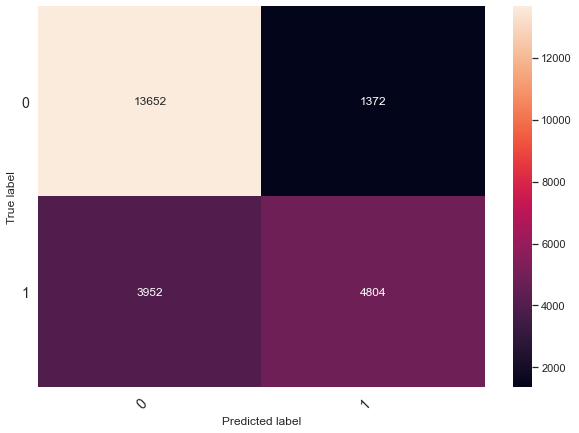

In [42]:
conf_mat = confusion_matrix(y_test, logreg.predict(X_test))
df_cm = pd.DataFrame(conf_mat, index=['0','1'], columns=['0', '1'],)
fig = plt.figure(figsize=[10,7])
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [43]:
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     15024
           1       0.78      0.55      0.64      8756

    accuracy                           0.78     23780
   macro avg       0.78      0.73      0.74     23780
weighted avg       0.78      0.78      0.77     23780



In [44]:
print(classification_report(y_train, logreg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     59721
           1       0.78      0.56      0.65     35397

    accuracy                           0.78     95118
   macro avg       0.78      0.73      0.74     95118
weighted avg       0.78      0.78      0.77     95118



## 4.4. Random Forest

In [45]:
tree_depth = [5, 10, 20]
for i in tree_depth:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(X_train, y_train)
    print('Max tree depth: ', i)
    print('Train results: ', classification_report(y_train, rf.predict(X_train)))
    print('Test results: ',classification_report(y_test, rf.predict(X_test)))

Max tree depth:  5
Train results:                precision    recall  f1-score   support

           0       0.73      1.00      0.84     59721
           1       1.00      0.37      0.54     35397

    accuracy                           0.77     95118
   macro avg       0.86      0.68      0.69     95118
weighted avg       0.83      0.77      0.73     95118

Test results:                precision    recall  f1-score   support

           0       0.73      1.00      0.84     15024
           1       1.00      0.36      0.53      8756

    accuracy                           0.76     23780
   macro avg       0.86      0.68      0.69     23780
weighted avg       0.83      0.76      0.73     23780

Max tree depth:  10
Train results:                precision    recall  f1-score   support

           0       0.75      0.99      0.85     59721
           1       0.95      0.43      0.60     35397

    accuracy                           0.78     95118
   macro avg       0.85      0.71      0.7

In [46]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(X_train, y_train)
print('Max tree depth: ', i)
print('Train results: ', classification_report(y_train, rf.predict(X_train)))
print('Test results: ',classification_report(y_test, rf.predict(X_test)))

Max tree depth:  20
Train results:                precision    recall  f1-score   support

           0       0.81      0.98      0.88     59721
           1       0.94      0.60      0.73     35397

    accuracy                           0.84     95118
   macro avg       0.87      0.79      0.81     95118
weighted avg       0.85      0.84      0.83     95118

Test results:                precision    recall  f1-score   support

           0       0.79      0.96      0.87     15024
           1       0.90      0.56      0.69      8756

    accuracy                           0.82     23780
   macro avg       0.84      0.76      0.78     23780
weighted avg       0.83      0.82      0.80     23780



# 5. Deployment

In [47]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

ModuleNotFoundError: No module named 'watson_machine_learning_client'

In [ ]:
wml_credentials = {
  "apikey": "Grx6jTQWN5Teytx2xgv5kfjkjsE3UDRQ96PdIL0BvHK1",
  "iam_apikey_description": "Auto-generated for key 4f6c4597-eaa9-409d-80ff-db70f5b455f5",
  "iam_apikey_name": "Hotelondemand",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/3c7d4992841443ca85cbdbf81cc0d50c::serviceid:ServiceId-e88db4be-843b-47e3-ad72-11da9a9148f2",
  "instance_id": "de6e2ea0-c8cb-4149-b160-ad36088724a8",
  "url": "https://us-south.ml.cloud.ibm.com"
}

In [71]:
wml_client = WatsonMachineLearningAPIClient(wml_credentials)

In [79]:
wml_client.repository.list()

------------------------------------  --------------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                        CREATED                   FRAMEWORK          TYPE
0eff356e-1173-4f80-b112-4d2cb35e3353  HotelOnDemand_Fallstudie    2020-07-12T18:12:57.300Z  scikit-learn-0.20  model
ace057e9-ffe2-47ef-9ef9-e3853ea5ef66  AIFallstudie_HotelOnDemand  2020-07-12T18:13:25.356Z  scikit-learn-0.20  online deployment
------------------------------------  --------------------------  ------------------------  -----------------  -----------------


In [73]:
metadata = {
        wml_client.repository.ModelMetaNames.NAME: 'HotelOnDemand_Fallstudie',
        wml_client.repository.ModelMetaNames.DESCRIPTION: 'Classification',
        wml_client.repository.ModelMetaNames.AUTHOR_NAME: 'ErsinBarut'
}

In [76]:
stored_model = wml_client.repository.store_model(rf, meta_props=metadata)

In [77]:
published_model_uid = wml_client.repository.get_model_uid(stored_model)

In [78]:
created_deployment = wml_client.deployments.create(published_model_uid, name="AIFallstudie_HotelOnDemand")
scoring_endpoint = wml_client.deployments.get_scoring_url(created_deployment)



#######################################################################################

Synchronous deployment creation for uid: '0eff356e-1173-4f80-b112-4d2cb35e3353' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ace057e9-ffe2-47ef-9ef9-e3853ea5ef66'
------------------------------------------------------------------------------------------------


